**Intro ML - Trabalho 1**

 O objetivo deste trabalho é identificar possíveis clientes inadimplentes na hora de aprovar produtos de crédito. Para isso, a técnica de classificação foi aplicada.

Importando bibliotecas

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from scipy.spatial.distance import pdist
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

Lendo os datasets de treino e de teste

In [18]:
df_train = pd.read_csv("./drive/MyDrive/Intro ML/Dados/conjunto_de_treinamento.csv")
df_test = pd.read_csv("./drive/MyDrive/Intro ML/Dados/conjunto_de_teste.csv")

Uma breve observação das colunas

In [19]:
df_train

,id_solicitante,produto_solicitado,dia_vencimento,forma_envio_solicitacao,tipo_endereco,sexo,idade,estado_civil,qtde_dependentes,grau_instrucao,nacionalidade,estado_onde_nasceu,estado_onde_reside,possui_telefone_residencial,codigo_area_telefone_residencial,tipo_residencia,meses_na_residencia,possui_telefone_celular,possui_email,renda_mensal_regular,renda_extra,possui_cartao_visa,possui_cartao_mastercard,possui_cartao_diners,possui_cartao_amex,possui_outros_cartoes,qtde_contas_bancarias,qtde_contas_bancarias_especiais,valor_patrimonio_pessoal,possui_carro,vinculo_formal_com_empresa,estado_onde_trabalha,possui_telefone_trabalho,codigo_area_telefone_trabalho,meses_no_trabalho,profissao,ocupacao,profissao_companheiro,grau_instrucao_companheiro,local_onde_reside,local_onde_trabalha,inadimplente
0,1,1,10,presencial,1,M,85,2,0,0,1,CE,CE,Y,107,1.0,12.0,N,0,480.0,0.0,0,0,0,0,0,1,1,0.0,1,N,,N,,0,9.0,1.0,0.0,0.0,600.0,600.0,0
1,2,1,25,internet,1,F,38,1,0,0,1,SE,SE,Y,91,1.0,5.0,N,1,380.0,0.0,0,0,0,0,0,0,0,0.0,0,N,,N,,0,2.0,5.0,NaN,NaN,492.0,492.0,0
2,3,1,20,internet,1,F,37,2,0,0,1,BA,BA,Y,90,5.0,1.0,N,1,600.0,0.0,0,0,0,0,0,0,0,0.0,0,N,,N,,0,NaN,NaN,NaN,NaN,450.0,450.0,1
3,4,1,20,internet,1,M,37,1,1,0,1,RS,RS,Y,54,1.0,1.0,N,1,460.0,0.0,0,0,0,0,0,0,0,0.0,0,Y,RS,Y,54,0,9.0,2.0,NaN,NaN,932.0,932.0,1
4,5,7,1,internet,1,F,51,1,3,0,1,BA,BA,Y,86,0.0,1.0,N,1,687.0,600.0,0,0,0,0,0,0,0,0.0,1,Y,BA,N,,0,9.0,5.0,NaN,NaN,440.0,440.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,19996,1,10,presencial,1,M,27,2,0,0,1,MG,MG,Y,29,2.0,0.0,N,1,423.0,0.0,0,0,0,0,0,1,1,0.0,1,Y,,N,,0,9.0,1.0,0.0,0.0,308.0,308.0,0
19996,19997,1,20,presencial,1,F,26,2,1,0,1,CE,CE,Y,107,1.0,3.0,N,0,350.0,0.0,0,0,0,0,0,1,1,0.0,1,Y,,N,,0,9.0,2.0,0.0,0.0,639.0,639.0,0
19997,19998,1,10,internet,1,F,63,2,0,0,1,BA,BA,Y,86,5.0,25.0,N,1,321.0,0.0,0,0,0,0,0,0,0,0.0,0,N,,N,,0,9.0,1.0,NaN,NaN,486.0,486.0,0
19998,19999,1,5,internet,1,F,84,1,0,0,1,PB,RN,N,,1.0,30.0,N,1,380.0,0.0,0,0,0,0,0,0,0,0.0,0,N,,N,,0,NaN,NaN,NaN,NaN,590.0,590.0,0


In [20]:
df_train.describe()

,id_solicitante,produto_solicitado,dia_vencimento,tipo_endereco,idade,estado_civil,qtde_dependentes,grau_instrucao,nacionalidade,tipo_residencia,meses_na_residencia,possui_email,renda_mensal_regular,renda_extra,possui_cartao_visa,possui_cartao_mastercard,possui_cartao_diners,possui_cartao_amex,possui_outros_cartoes,qtde_contas_bancarias,qtde_contas_bancarias_especiais,valor_patrimonio_pessoal,possui_carro,meses_no_trabalho,profissao,ocupacao,profissao_companheiro,grau_instrucao_companheiro,local_onde_reside,local_onde_trabalha,inadimplente
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.0,20000.000000,19464.000000,18550.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,2.000000e+04,20000.000000,20000.000000,16903.000000,17022.000000,8486.000000,7140.000000,20000.000000,20000.000000,20000.000000
mean,10000.500000,1.284350,13.147250,1.006350,42.352500,2.120850,0.666400,0.0,0.961600,1.261303,9.572453,0.799200,957.130937,39.096958,0.108900,0.094950,0.001600,0.002050,0.002250,0.361100,0.361100,2.095614e+03,0.339050,0.008900,8.045081,2.533310,3.708107,0.288095,581.295250,581.295250,0.500000
std,5773.647028,1.008239,6.748507,0.079435,14.930177,1.332004,1.236725,0.0,0.202305,0.883580,10.649580,0.400609,11353.965001,1387.428780,0.311521,0.293153,0.039969,0.045232,0.047382,0.481164,0.481164,4.403344e+04,0.473399,0.388881,3.210790,1.532765,5.181241,0.944339,227.369798,227.369798,0.500013
min,1.000000,1.000000,1.000000,1.000000,7.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,69.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,105.000000,0.000000
25%,5000.750000,1.000000,10.000000,1.000000,31.000000,1.000000,0.000000,0.0,1.000000,1.000000,1.000000,1.000000,360.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,9.000000,1.000000,0.000000,0.000000,444.000000,444.000000,0.000000
50%,10000.500000,1.000000,10.000000,1.000000,40.000000,2.000000,0.000000,0.0,1.000000,1.000000,6.000000,1.000000,500.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,9.000000,2.000000,0.000000,0.000000,596.000000,596.000000,0.500000
75%,15000.250000,1.000000,20.000000,1.000000,52.000000,2.000000,1.000000,0.0,1.000000,1.000000,15.000000,1.000000,800.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000e+00,1.000000,0.000000,9.000000,4.000000,11.000000,0.000000,728.000000,728.000000,1.000000
max,20000.000000,7.000000,25.000000,2.000000,106.000000,7.000000,53.000000,0.0,2.000000,5.000000,228.000000,1.000000,959000.000000,194344.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,6.000000e+06,1.000000,32.000000,17.000000,5.000000,17.000000,5.000000,999.000000,999.000000,1.000000


In [21]:
df_train.select_dtypes(exclude=[np.number])

,forma_envio_solicitacao,sexo,estado_onde_nasceu,estado_onde_reside,possui_telefone_residencial,codigo_area_telefone_residencial,possui_telefone_celular,vinculo_formal_com_empresa,estado_onde_trabalha,possui_telefone_trabalho,codigo_area_telefone_trabalho
0,presencial,M,CE,CE,Y,107,N,N,,N,
1,internet,F,SE,SE,Y,91,N,N,,N,
2,internet,F,BA,BA,Y,90,N,N,,N,
3,internet,M,RS,RS,Y,54,N,Y,RS,Y,54
4,internet,F,BA,BA,Y,86,N,Y,BA,N,
...,...,...,...,...,...,...,...,...,...,...,...
19995,presencial,M,MG,MG,Y,29,N,Y,,N,
19996,presencial,F,CE,CE,Y,107,N,Y,,N,
19997,internet,F,BA,BA,Y,86,N,N,,N,
19998,internet,F,PB,RN,N,,N,N,,N,


Através dessa breve observação foi possível perceber que as colunas *grau_instrucao* e *id_solicitante* não contribuem para o resultado e por isso devem ser removidas.

In [22]:
df_train = df_train.drop(columns=['grau_instrucao', 'id_solicitante'])
id_test = df_test['id_solicitante']
df_test = df_test.drop(columns=['grau_instrucao', 'id_solicitante'])

Para analisar a presença de dados faltantes, uma tabela com o número e porcentagem desses dados foi gerada.

In [23]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
grau_instrucao_companheiro,12860,0.64300
profissao_companheiro,11514,0.57570
profissao,3097,0.15485
ocupacao,2978,0.14890
meses_na_residencia,1450,0.07250
tipo_residencia,536,0.02680
inadimplente,0,0.00000
nacionalidade,0,0.00000
possui_telefone_celular,0,0.00000
codigo_area_telefone_residencial,0,0.00000


Percebe-se a presença de dados faltantes. As colunas que possuem mais de 16% de dados faltantes e as linhas restantes com dados ausentes foram eliminadas.

In [24]:
df_train = df_train.drop((missing_data[missing_data['Percent'] > 0.16]).index, 1)
df_train = df_train.dropna()
df_test = df_test.drop((missing_data[missing_data['Percent'] > 0.16]).index, 1)

In [25]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
inadimplente,0,0.0
estado_onde_nasceu,0,0.0
possui_email,0,0.0
possui_telefone_celular,0,0.0
meses_na_residencia,0,0.0
tipo_residencia,0,0.0
codigo_area_telefone_residencial,0,0.0
possui_telefone_residencial,0,0.0
estado_onde_reside,0,0.0
nacionalidade,0,0.0


Para analisar melhor as variáveis categóricas uma tabela contendo sua cardinalidade foi gerada.

In [26]:
def get_card_cat_var():
  card_cat_var = pd.DataFrame()
  for column in df_train.select_dtypes(exclude=[np.number]).columns:
    card_cat_var = card_cat_var.append({'Coluna': column, 'Cardinalidade': len(df_train[column].unique())}, ignore_index=True)
  return card_cat_var

get_card_cat_var()

,Cardinalidade,Coluna
0,3.0,forma_envio_solicitacao
1,4.0,sexo
2,28.0,estado_onde_nasceu
3,27.0,estado_onde_reside
4,2.0,possui_telefone_residencial
5,79.0,codigo_area_telefone_residencial
6,1.0,possui_telefone_celular
7,2.0,vinculo_formal_com_empresa
8,28.0,estado_onde_trabalha
9,2.0,possui_telefone_trabalho


Os estados na coluna *estado_onde_reside* foram substituídos por suas regiões por entender que as diferenças demográficas ocorrem mais entre diferentes regiões do que entre diferentes estados de uma mesma região. As variaveis *estado_onde_nasceu* e *estado_onde_trabalha* foram removidas por não acrescentarem informações relevantes.

In [27]:
estados = {
    'AM': 'Norte',
    'BA': 'Nordeste',
    'CE': 'Nordeste',
    'PE': 'Nordeste',
    'MG': 'Sudeste',
    'PA': 'Nordeste',
    'GO': 'Centro-Oeste',
    'RJ': 'Sudeste',
    'PR': 'Sul',
    'SP': 'Sudeste',
    'RN': 'Nordeste',
    'MT': 'Centro-Oeste',
    'AL': 'Nordeste',
    'PB': 'Nordeste',
    'RS': 'Sul',
    'TO': 'Norte',
    'MA': 'Nordeste',
    'RR': 'Norte',
    'MS': 'Centro-Oeste',
    'ES': 'Sudeste',
    'DF': 'Centro-Oeste',
    'PI': 'Norte',
    'SC': 'Sul',
    'AP': 'Norte',
    'SE': 'Nordeste',
    'RO': 'Norte',
    'AC': 'Norte'
}

df_train['estado_onde_reside'].replace(estados, inplace=True)
df_test['estado_onde_reside'].replace(estados, inplace=True)

df_train = df_train.drop(columns=['estado_onde_nasceu', 'estado_onde_trabalha'])
df_test = df_test.drop(columns=['estado_onde_nasceu', 'estado_onde_trabalha'])

Mais colunas irrelevantes foram removidas e valores vazios foram substituídos por N na coluna *sexo*.

In [28]:
df_train = df_train.drop(columns=['possui_telefone_celular', 'possui_telefone_residencial', 'codigo_area_telefone_residencial',
                                  'possui_telefone_trabalho', 'codigo_area_telefone_trabalho'])
df_train['sexo'].replace({' ': 'N'}, inplace=True)
df_test['sexo'].replace({' ': 'N'}, inplace=True)

df_test = df_test.drop(columns=['possui_telefone_celular', 'possui_telefone_residencial', 'codigo_area_telefone_residencial',
                                  'possui_telefone_trabalho', 'codigo_area_telefone_trabalho'])


get_card_cat_var()

,Cardinalidade,Coluna
0,3.0,forma_envio_solicitacao
1,3.0,sexo
2,5.0,estado_onde_reside
3,2.0,vinculo_formal_com_empresa


Após a limpeza e ajustes de cardinalidade, as variáveis *forma_envio_solicitacao* e *estado_onde_reside* passaram por One-hot encoding e as variáveis *sexo* e *vinculo_formal_com_empresa* foram binarizadas.

In [29]:
binarias = ['sexo', 'vinculo_formal_com_empresa']
nao_binarias = ['forma_envio_solicitacao', 'estado_onde_reside']

df_train = pd.get_dummies(df_train,columns=nao_binarias)
df_test = pd.get_dummies(df_test,columns=nao_binarias)

binarizador = LabelBinarizer()

for i in binarias:
    df_train[i] = binarizador.fit_transform(df_train[i])
    df_test[i] = binarizador.fit_transform(df_test[i])

Com as variáveis categóricas arrumadas, a matriz de correlação pôde ser gerada.

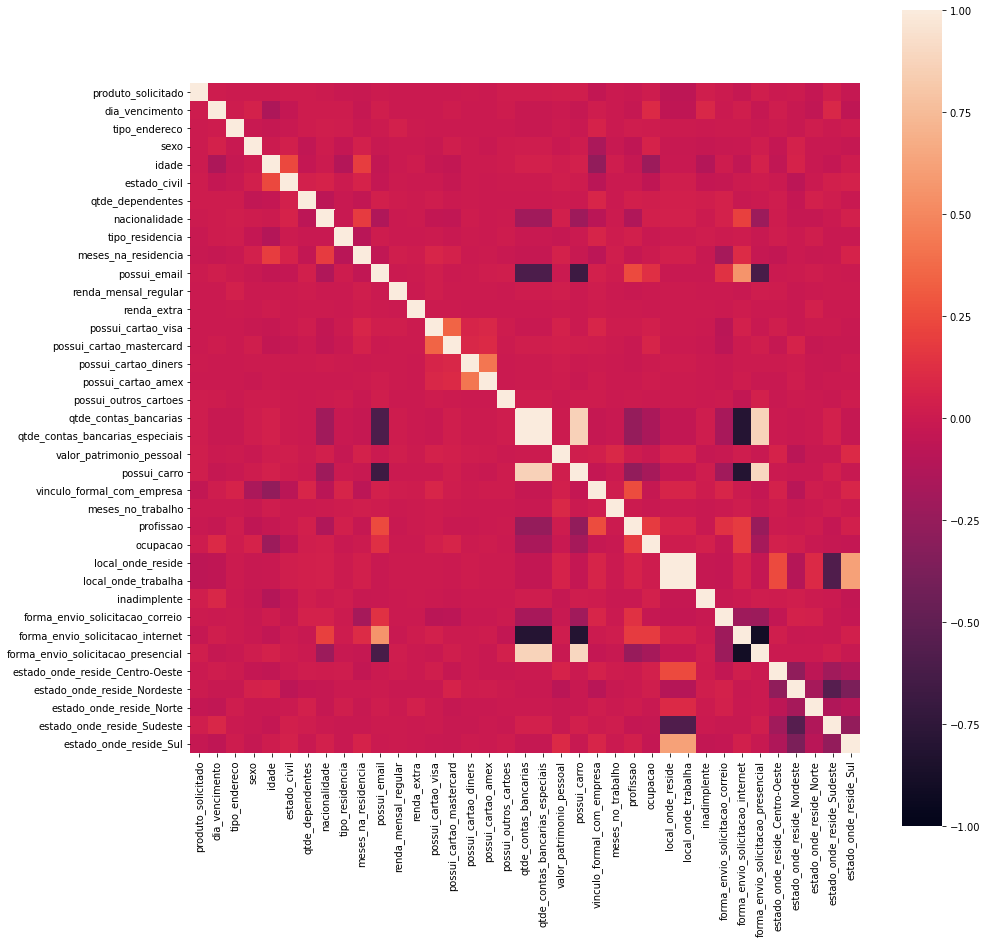

In [30]:
corrmat = df_train.corr()
plt.subplots(figsize=(15, 15))
sns.heatmap(corrmat, vmin=-1, vmax= 1, square=True)

A validação cruzada e a raiz do erro médio quadrático foram utilizados para testar e validar os modelos.

In [31]:
y_train = df_train['inadimplente']
x_train = df_train.drop(columns=['inadimplente'])

kf = KFold(n_splits=5)

def cv(model, x=x_train, y=y_train):
    return -cross_val_score(model, x, y, cv=kf, scoring='neg_root_mean_squared_error')

In [33]:
dtree = DecisionTreeClassifier()
score = cv(dtree)
print("dtree: {:.4f} ± {:.4f}".format(score.mean(), score.std()))

dtree: 0.6986 ± 0.0028


In [34]:
rf = RandomForestClassifier()
score = cv(rf)
print("rf: {:.4f} ± {:.4f}".format(score.mean(), score.std()))

rf: 0.6691 ± 0.0051


In [35]:
gbc = GradientBoostingClassifier()
score = cv(gbc)
print("gbc: {:.4f} ± {:.4f}".format(score.mean(), score.std()))

gbc: 0.6563 ± 0.0059


In [36]:
svc = svm.SVC()
score = cv(svc)
print("svc: {:.4f} ± {:.4f}".format(score.mean(), score.std()))

svc: 0.7091 ± 0.0045


In [37]:
mlp = MLPClassifier(activation='logistic')
score = cv(mlp)
print("mlp: {:.4f} ± {:.4f}".format(score.mean(), score.std()))

mlp: 0.6715 ± 0.0033


Para rodar o modelo no dataset de teste, seus valores ausentes foram substituídos pelo valor médio.

In [38]:
imputer_test = SimpleImputer(missing_values=np.nan, strategy="mean")
df_test = imputer_test.fit_transform(df_test)

O modelo do classificador de Gradient Boosting foi o que apresentou menor erro e por isso foi escolhido para rodar no dataset de teste.

In [39]:
gbc.fit(x_train, y_train)

y_submission = gbc.predict(df_test)

submission = pd.DataFrame({'id_solicitante': id_test, 'inadimplente': y_submission})
submission.to_csv('./submission.csv', index=False)